In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from numba import njit
import tensorflow as tf

In [2]:
from sbi.models import BayesFlow, InvariantNetwork
from sbi.trainers import BasicTrainer
from sbi.losses import *
from sbi.diagnostics import *

In [3]:
%load_ext autoreload
%autoreload 2

# Simulator settings

In [4]:
def prior(batch_size):
    """
    Samples from the prior 'batch_size' times.
    ----------
    
    Arguments:
    batch_size : int -- the number of samples to draw from the prior
    ----------
    
    Output:
    theta : np.ndarray of shape (batch_size, theta_dim) -- the samples batch of parameters
    """
    
    # Prior ranges for the simulator 
    # v_c ~ U(-7.0, 7.0)
    # a_c ~ U(0.1, 4.0)
    # t0 ~ U(0.1, 3.0)
    p_samples = np.random.uniform(low=(0.1, 0.1, 0.1, 0.1, 0.1), 
                                  high=(7.0, 7.0, 4.0, 4.0, 3.0), size=(batch_size, 5))
    return p_samples.astype(np.float32)


@njit
def diffusion_trial(v, a, ndt, zr, dt, max_steps):
    """Simulates a trial from the diffusion model."""

    n_steps = 0.
    x = a * zr

    # Simulate a single DM path
    while (x > 0 and x < a and n_steps < max_steps):

        # DDM equation
        x += v*dt + np.sqrt(dt) * np.random.normal()

        # Increment step
        n_steps += 1.0

    rt = n_steps * dt
    return rt + ndt if x > 0. else -rt - ndt

@njit
def diffusion_condition(n_trials, v, a, ndt, zr=0.5, dt=0.005, max_steps=1e4):
    """Simulates a diffusion process over an entire condition."""
    
    x = np.empty(n_trials)
    for i in range(n_trials):
        x[i] = diffusion_trial(v, a, ndt, zr, dt, max_steps)
    return x


@njit
def diffusion_2_conds(params, n_trials, dt=0.005, max_steps=1e4):
    """
    Simulates a diffusion process for 2 conditions with 5 parameters (v1, v2, a1, a2, ndt).
    """
    
    n_trials_c1 = n_trials[0]
    n_trials_c2 = n_trials[1]
    
    v1, v2, a1, a2, ndt = params
    rt_c1 = diffusion_condition(n_trials_c1, v1, a1, ndt,  dt=dt, max_steps=max_steps)
    rt_c2 = diffusion_condition(n_trials_c2, v2, a2, ndt, dt=dt, max_steps=max_steps)
    rts = np.concatenate((rt_c1, rt_c2))
    return rts

def batch_simulator(prior_samples, n_obs, dt=0.005, s=1.0, max_iter=1e4):
    """
    Simulate multiple diffusion_model_datasets.
    """
    
    n_sim = prior_samples.shape[0]
    sim_data = np.empty((n_sim, n_obs), dtype=np.float32)
    
    n1 = n_obs//2
    n2 = n_obs - n1
    
    # Simulate diffusion data
    for i in range(n_sim):
        sim_data[i] = diffusion_2_conds(prior_samples[i], (n1, n2))
        
    # Create condition labels
    cond_arr = np.stack(n_sim * [np.concatenate((np.zeros(n1), np.ones(n2)))] )
    sim_data = np.stack((sim_data, cond_arr), axis=-1)
    
    return sim_data

# An example Bayesian workflow (with BayesFlow)

Towards a principled Bayesian workflow for cognitive modeling:

https://betanalpha.github.io/assets/case_studies/principled_bayesian_workflow.html

https://arxiv.org/abs/1904.12765

## Prior predictive checks

In [35]:
# Add stuff

## Train amortized estimator
Here, we use an invariant summary network.

In [5]:
sum_meta = {
    'n_dense_s1': 2,
    'n_dense_s2': 2,
    'n_dense_s3': 2,
    'n_equiv':    2,
    'dense_s1_args': {'activation': 'relu', 'units': 32},
    'dense_s2_args': {'activation': 'relu', 'units': 64},
    'dense_s3_args': {'activation': 'relu', 'units': 32},
}

bf_meta = {
    'n_coupling_layers': 3,
    's_args': {
        'units': [128, 128],
        'activation': 'elu',
        'initializer': 'glorot_uniform',
    },
    't_args': {
        'units': [128, 128],
        'activation': 'elu',
        'initializer': 'glorot_uniform',
    },
    'n_params': 5,
    'alpha': 1.9,
    'permute': True
}

In [6]:
summary_net = InvariantNetwork(sum_meta)
bayes_flow = BayesFlow(bf_meta, summary_net=summary_net)

In [24]:
trainer = BasicTrainer(network=bayes_flow, 
                       prior=prior, 
                       simulator=batch_simulator, 
                       n_obs=100,
                       loss=kl_latent_space, 
                       checkpoint_path='checkpoints/dm_new')

Networks loaded from checkpoints/dm_new\ckpt-17


### Offline training

In [8]:
# Pre-simulated data (could be loaded from somewhere else)
n_sim = 1000
n_obs = 100
true_params = prior(n_sim)
x = batch_simulator(true_params, n_obs)

In [9]:
%%time
losses = trainer.train_offline(epochs=2, batch_size=32, params=true_params, sim_data=x)

Converting 1000 simulations to a TensorFlow data set...


Training epoch 1:   0%|          | 0/32 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/32 [00:00<?, ?it/s]

Wall time: 8.89 s


In [ ]:
# Using an internal simulation loop

In [10]:
%%time
losses = trainer.simulate_and_train_offline(n_sim=1000, epochs=2, batch_size=32)

Simulating 1000 data sets upfront...
Converting 1000 simulations to a TensorFlow data set...


Training epoch 1:   0%|          | 0/32 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/32 [00:00<?, ?it/s]

Wall time: 7.82 s


### Online training

In [12]:
%%time
losses = trainer.train_online(epochs=2, iterations_per_epoch=100, batch_size=32)

Training epoch 1:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/100 [00:00<?, ?it/s]

Wall time: 28.6 s


### Round-based training

In [11]:
%%time
losses = trainer.train_rounds(epochs=1, rounds=5, sim_per_round=200, batch_size=32)

Simulating initial 200 data sets...
Converting 200 simulations to a TensorFlow data set...


Training epoch 1:   0%|          | 0/7 [00:00<?, ?it/s]

Simulating new 200 data sets and appending to previous...
New total number of simulated data sets: 400
Converting 400 simulations to a TensorFlow data set...


Training epoch 1:   0%|          | 0/13 [00:00<?, ?it/s]

Simulating new 200 data sets and appending to previous...
New total number of simulated data sets: 600
Converting 600 simulations to a TensorFlow data set...


Training epoch 1:   0%|          | 0/19 [00:00<?, ?it/s]

Simulating new 200 data sets and appending to previous...
New total number of simulated data sets: 800
Converting 800 simulations to a TensorFlow data set...


Training epoch 1:   0%|          | 0/25 [00:00<?, ?it/s]

Simulating new 200 data sets and appending to previous...
New total number of simulated data sets: 1000
Converting 1000 simulations to a TensorFlow data set...


Training epoch 1:   0%|          | 0/32 [00:00<?, ?it/s]

Wall time: 13.7 s


### Experience-replay training

In [15]:
%%time
losses = trainer.train_experience_replay(epochs=3, batch_size=32, iterations_per_epoch=100, capacity=100)

Training epoch 1:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/100 [00:00<?, ?it/s]

Wall time: 43.1 s


### Variable n_obs

In [25]:
def prior_N(n_min=60, n_max=300):
    return np.random.randint(n_min, n_max+1)

In [26]:
trainer.n_obs = prior_N

In [23]:
%%time
losses = trainer.train_online(epochs=2, iterations_per_epoch=100, batch_size=32)

Training epoch 1:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/100 [00:00<?, ?it/s]

Wall time: 27.3 s


In [ ]:
# Offline learning and round-based learning would currenty only work with fixed N

In [27]:
%%time
losses = trainer.simulate_and_train_offline(n_sim=1000, epochs=2, batch_size=32)

AssertionError: Offline training currently only works with fixed n_obs. Use online learning for varibale n_obs

In [28]:
%%time
losses = trainer.train_rounds(3, 3, 100, 32)

AssertionError: Round-based training currently only works with fixed n_obs. Use online learning for varibale n_obs

## Compuational faithfulness
(Via simulation-based calibration)

In [17]:
n_sbc = 5000
n_post_samples_sbc = 250
params_sbc = prior(n_sbc)
x_sbc = batch_simulator(params_sbc, 100)
param_samples = np.concatenate([bayes_flow.sample(x, n_post_samples_sbc) 
                                for x in tf.split(x_sbc, 10, axis=0)], axis=1)

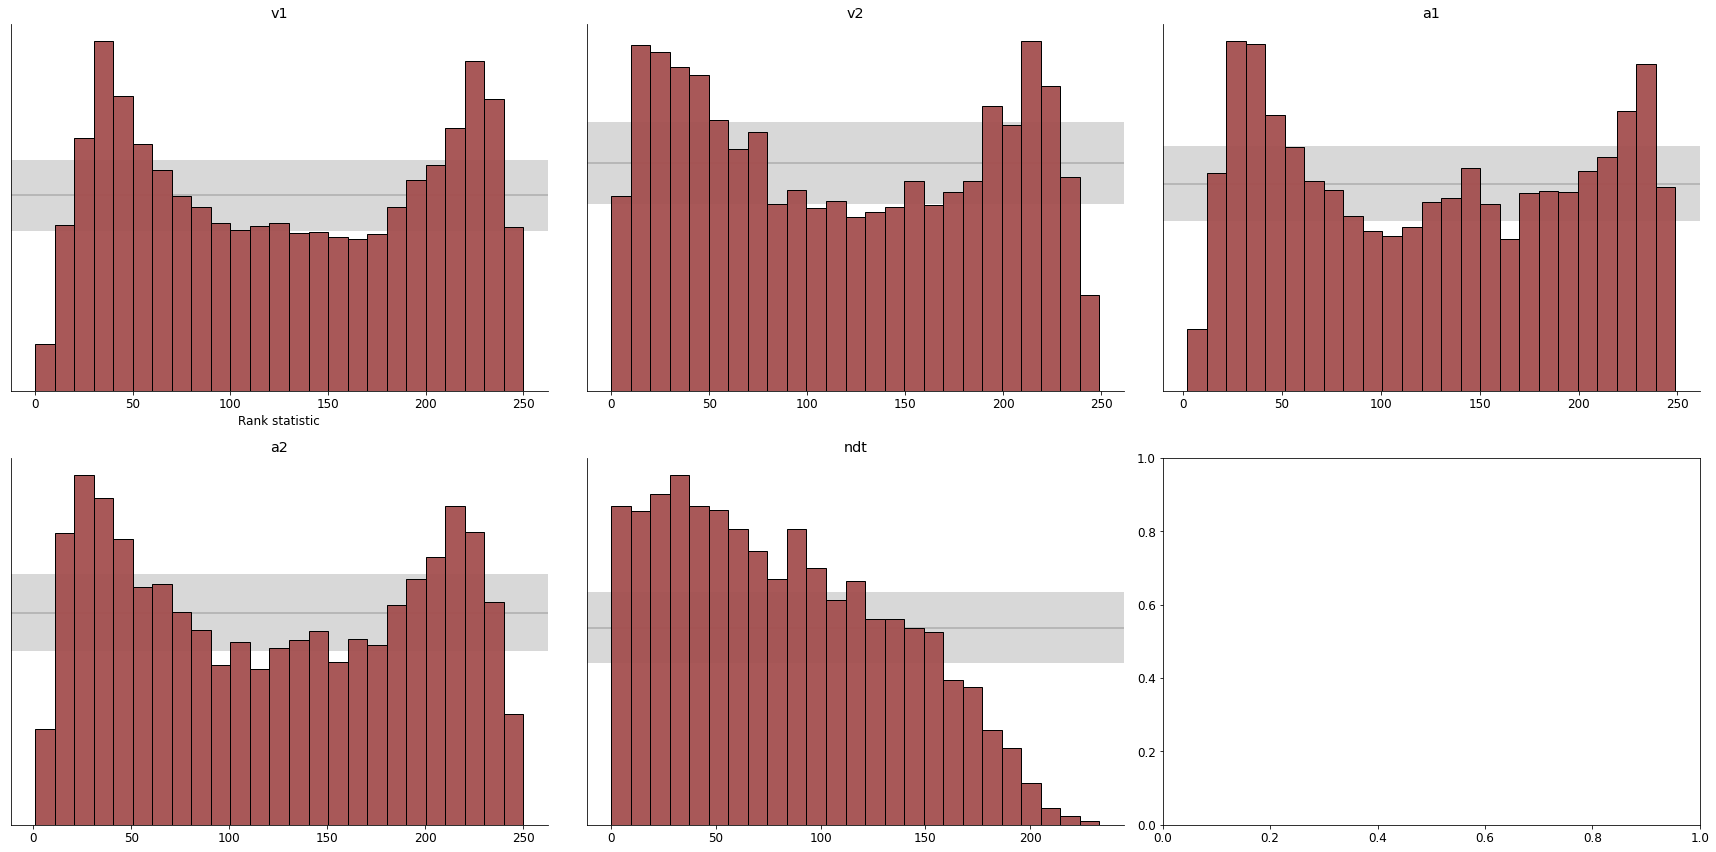

In [19]:
f = plot_sbc(param_samples, params_sbc, param_names=['v1', 'v2', 'a1', 'a2', 'ndt'])

## Model sensitivity/adequacy

### Quick and dirty

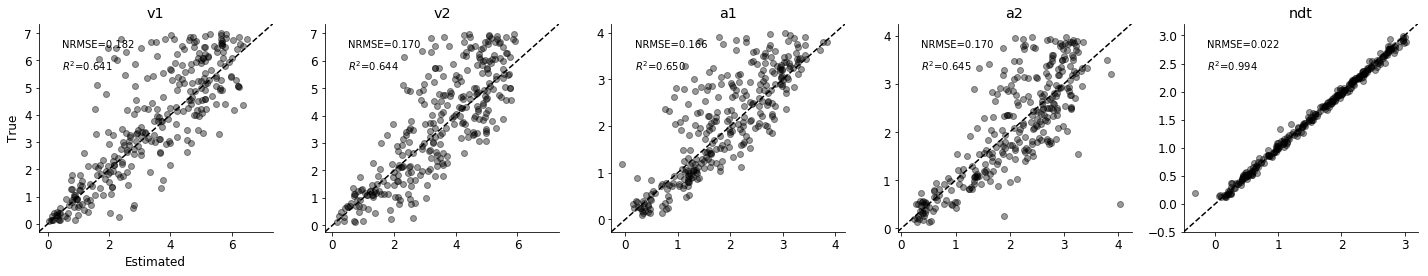

In [49]:
# Validate (quick and dirty)
true_params = prior(300)
x = batch_simulator(true_params).astype(np.float32)
param_samples = bayes_flow.sample(x, n_samples=1000)
param_means = param_samples.mean(axis=0)
true_vs_estimated(true_params, param_means, ['v1', 'v2', 'a1', 'a2','ndt'])

### A Bayesian eyechart

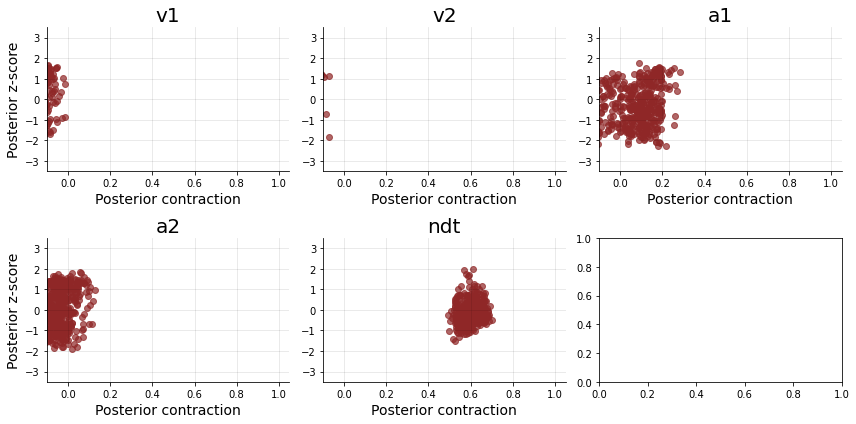

In [16]:
# Simulate
param_names = ['v1', 'v2', 'a1', 'a2','ndt']
n_sim_s = 500
n_samples_posterior = 1000
true_params = prior(n_sim_s)
x = batch_simulator(true_params)

# Sample from posterior
param_samples = bayes_flow.sample(x, n_samples_posterior)

### Posterior z-score
# Compute posterior means and stds
post_means = param_samples.mean(0)
post_stds = param_samples.std(0)
post_vars = param_samples.var(0)

# Compute posterior z score
post_z_score = (post_means - true_params) / post_stds

### Posterior contraction, i.e., 1 - post_var / prior_var
prior_a = (0.1, 0.1, 0.1, 0.1, 0.1) # lower bound of uniform prior
prior_b = (7.0, 7.0, 4.0, 4.0, 3.0) # upper bound of uniform prior

# Compute prior vars analytically
prior_vars = np.array([(b-a)**2/12 for a,b in zip(prior_a, prior_b)])
post_cont = 1 - post_vars / prior_vars

# Plotting time
f, axarr = plt.subplots(2, 3, figsize=(12, 6))
for i, (p, ax) in enumerate(zip(param_names, axarr.flat)):
    

    ax.scatter(post_cont[:, i], post_z_score[:, i], color='#8f2727', alpha=0.7)
    ax.set_title(p, fontsize=20)
    sns.despine(ax=ax)
    ax.set_xlim([-0.1, 1.05])
    ax.set_ylim([-3.5, 3.5])
    ax.grid(color='black', alpha=0.1)
    ax.set_xlabel('Posterior contraction', fontsize=14)
    if i == 0 or i == 3:
        ax.set_ylabel('Posterior z-score', fontsize=14)
f.tight_layout()

## Posterior postdictive/predictive checks